Finite difference grad (raw, no projection): [0.60941291 0.60941291 0.60941291 0.60941291 0.60941291]
Analytical grad: [0.60943791 0.60943791 0.60943791 0.60943791 0.60943791]
Grad difference norm: 5.590077120046682e-05


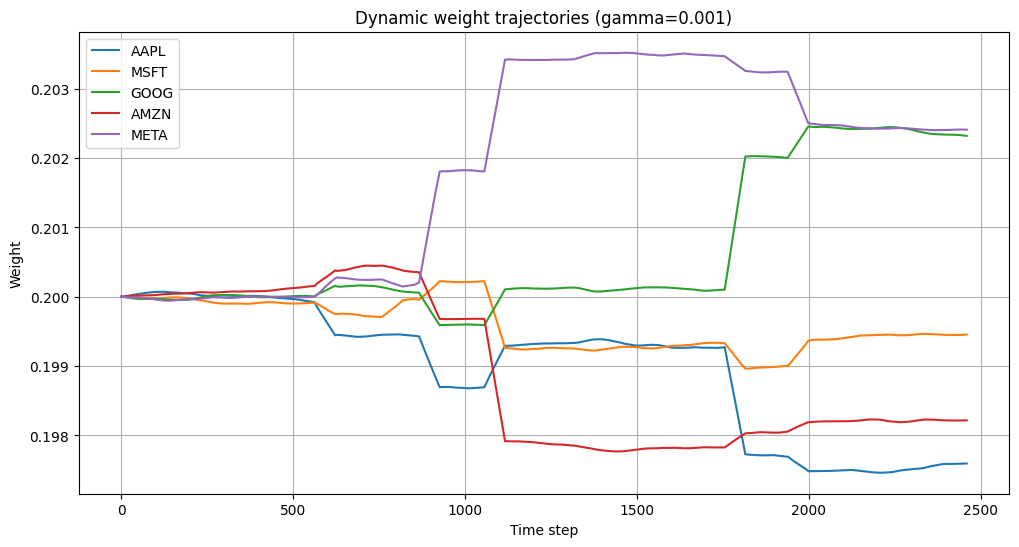

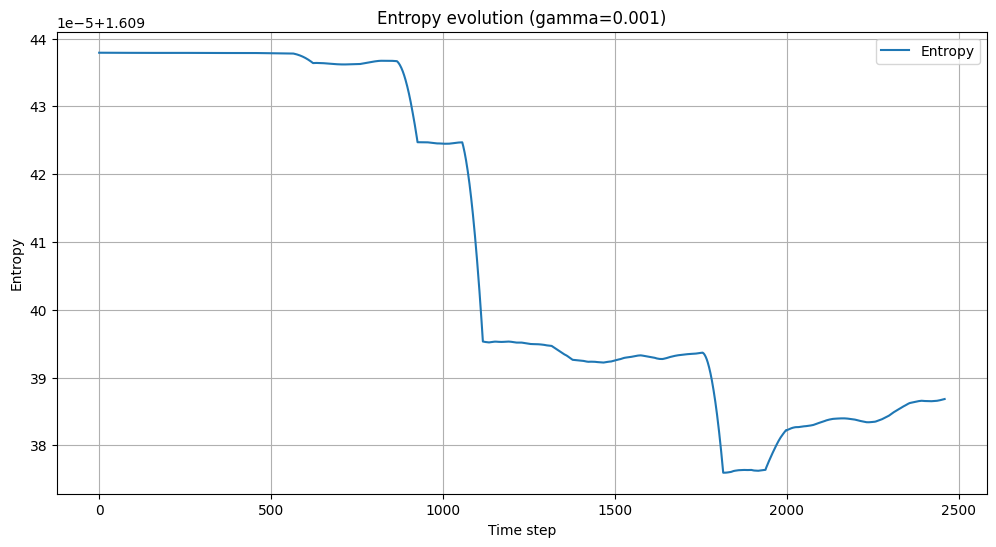

Final entropy (gamma=0.001): 1.6094
Final weights (gamma=0.001): [0.19759591 0.19945587 0.20232027 0.19821767 0.20241027]



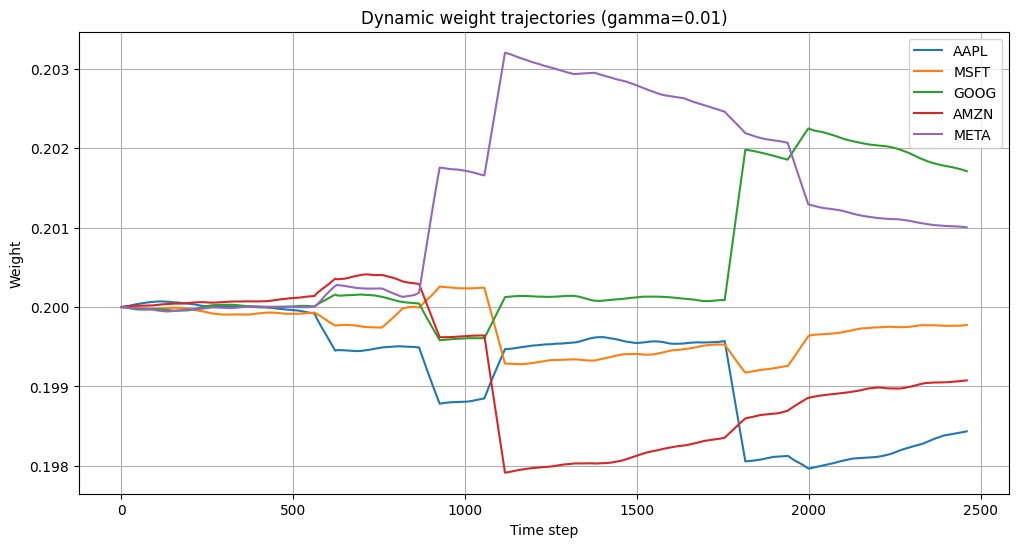

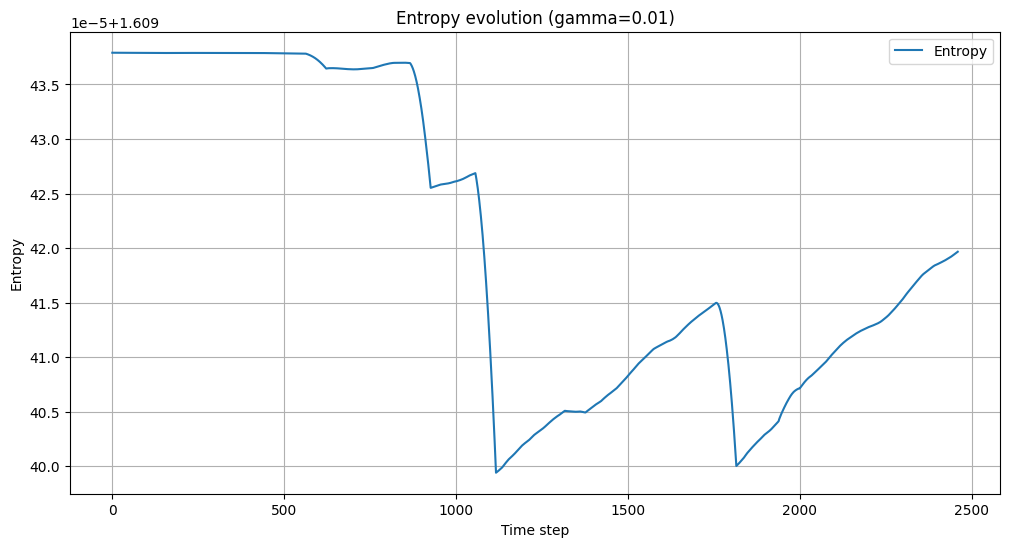

Final entropy (gamma=0.01): 1.6094
Final weights (gamma=0.01): [0.19843388 0.19977382 0.20171215 0.19907586 0.20100429]



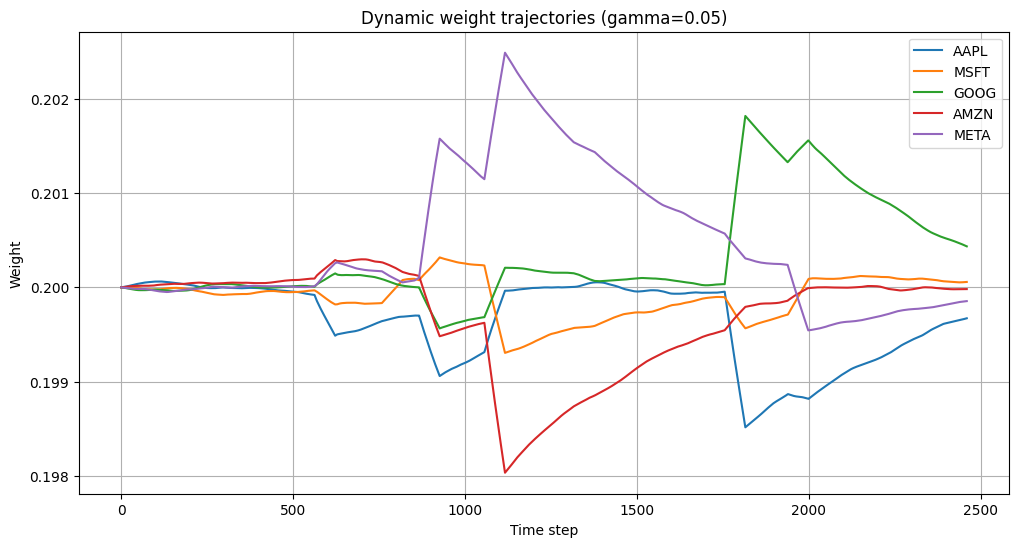

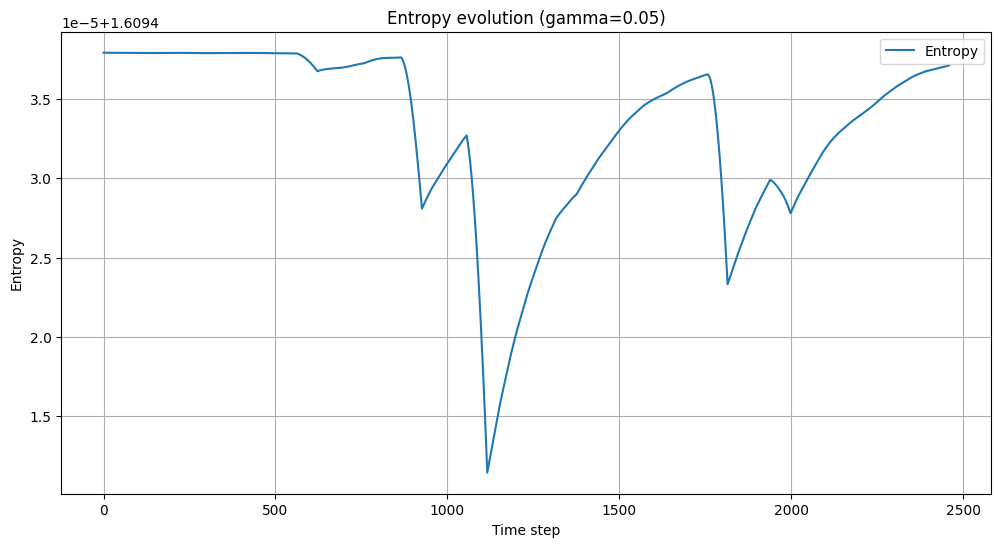

Final entropy (gamma=0.05): 1.6094
Final weights (gamma=0.05): [0.19967174 0.2000574  0.20043527 0.19998159 0.199854  ]



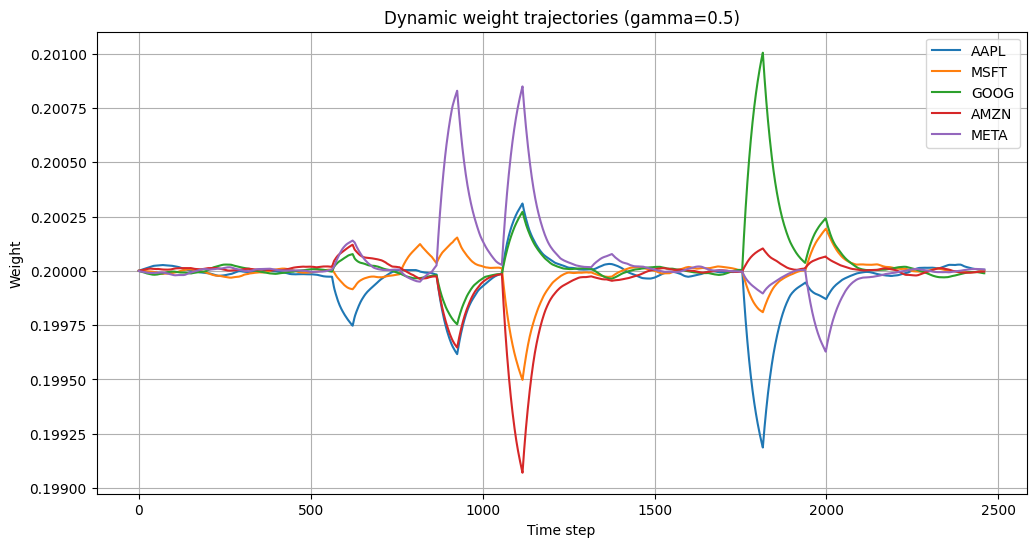

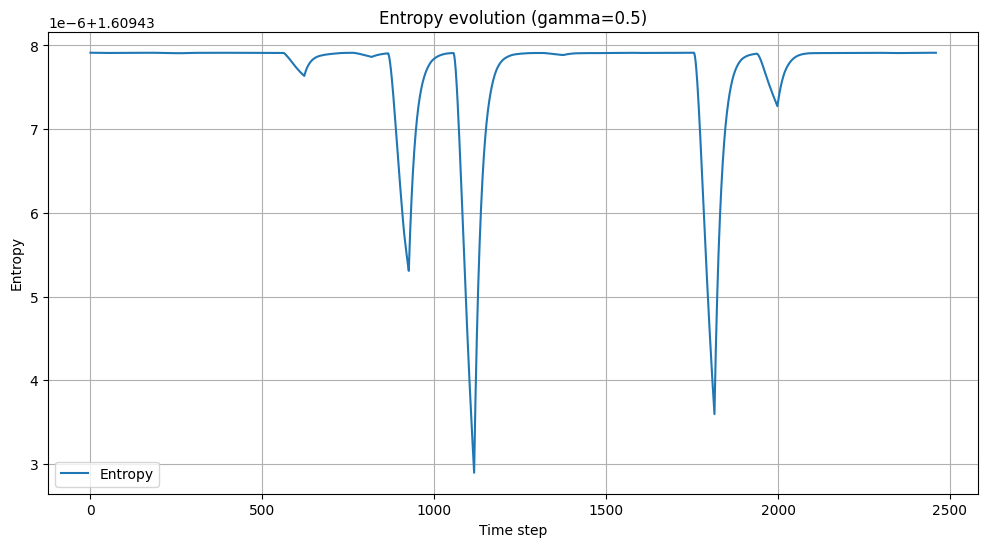

Final entropy (gamma=0.5): 1.6094
Final weights (gamma=0.5): [0.20000529 0.200003   0.19998897 0.19999671 0.20000603]



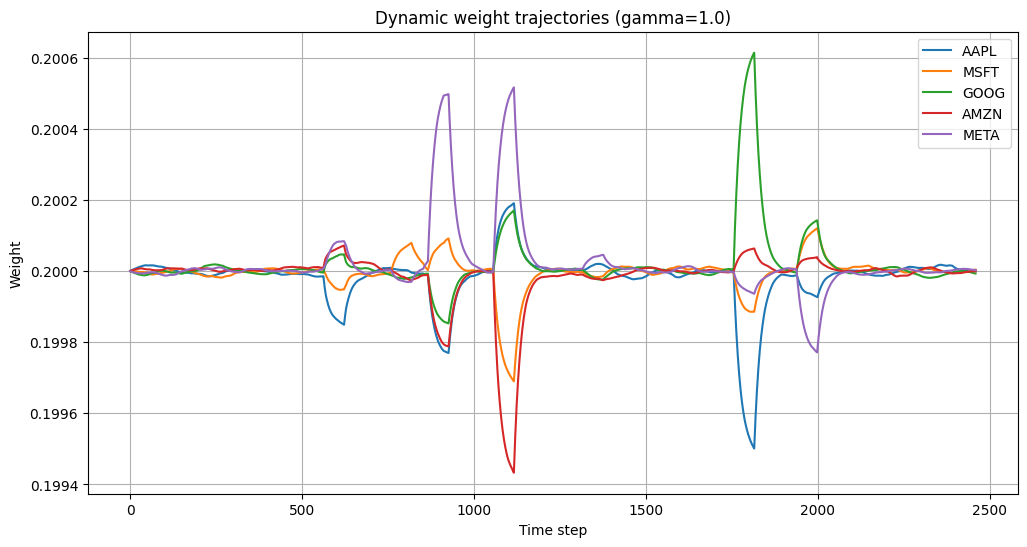

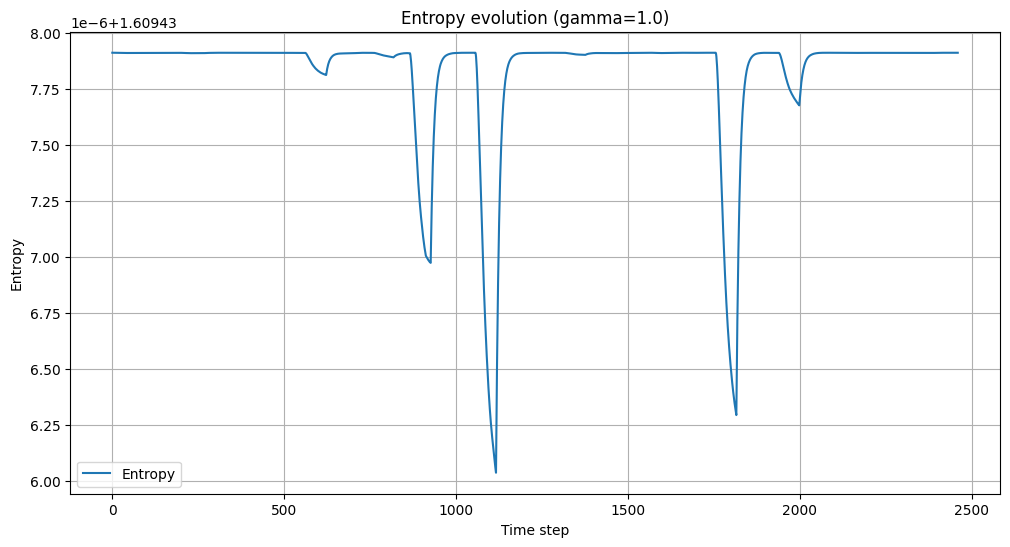

Final entropy (gamma=1.0): 1.6094
Final weights (gamma=1.0): [0.2000012  0.20000407 0.19999319 0.19999904 0.2000025 ]



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# Utility functions
# -----------------------

def entropy(weights):
    return -np.sum(weights * np.log(weights + 1e-12))

def entropy_gradient(weights):
    return -(1 + np.log(weights + 1e-12))

def projected_simplex(v, s=1):
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = (cssv[rho] - s) / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w

def portfolio_variance_gradient(weights, cov_matrix):
    return 2 * np.dot(cov_matrix, weights)

# -----------------------
# Data and shocks
# -----------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

# Stronger shocks
shock_days = np.random.choice(np.arange(500, 2000), size=10, replace=False)
for d in shock_days:
    returns.iloc[d] += np.random.normal(0, 0.3, size=len(assets))

# -----------------------
# Parameters
# -----------------------

gamma_values = [0.001, 0.01, 0.05, 0.5, 1.0]

# -----------------------
# Gradient finite diff test
# -----------------------

def finite_diff_entropy_test(weights, eps=1e-5):
    grad_approx = np.zeros_like(weights)
    base_entropy = entropy(weights)
    for i in range(len(weights)):
        perturbed = weights.copy()
        perturbed[i] += eps
        grad_approx[i] = (entropy(perturbed) - base_entropy) / eps
    analytical_grad = entropy_gradient(weights)
    print("Finite difference grad (raw, no projection):", grad_approx)
    print("Analytical grad:", analytical_grad)
    print("Grad difference norm:", np.linalg.norm(grad_approx - analytical_grad))

finite_diff_entropy_test(np.ones(len(assets)) / len(assets))

# -----------------------
# Dynamics and evolution
# -----------------------

for gamma in gamma_values:
    weights = np.ones(len(assets)) / len(assets)
    weights_history = []
    entropy_history = []

    for t in range(60, len(returns)):
        # Rolling covariance over recent 60 days
        window_returns = returns.iloc[t-60:t]
        cov_matrix = window_returns.cov().values

        grad_L = portfolio_variance_gradient(weights, cov_matrix)
        grad_H = entropy_gradient(weights)
        update = -0.05 * (grad_L - gamma * grad_H)
        new_weights = weights * np.exp(update)
        new_weights /= np.sum(new_weights)
        new_weights = projected_simplex(new_weights)

        weights = new_weights
        weights_history.append(weights.copy())
        entropy_history.append(entropy(weights))

    weights_history = np.array(weights_history)

    # Plot weights
    plt.figure(figsize=(12, 6))
    for i in range(weights_history.shape[1]):
        plt.plot(weights_history[:, i], label=assets[i])
    plt.title(f"Dynamic weight trajectories (gamma={gamma})")
    plt.xlabel("Time step")
    plt.ylabel("Weight")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot entropy
    plt.figure(figsize=(12, 6))
    plt.plot(entropy_history, label="Entropy")
    plt.title(f"Entropy evolution (gamma={gamma})")
    plt.xlabel("Time step")
    plt.ylabel("Entropy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final entropy (gamma={gamma}): {entropy(weights):.4f}")
    print(f"Final weights (gamma={gamma}): {weights}\n")
